In [2]:
#benchmark
#TF-IDF + SVM
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Data preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# Split MBTI type into four binary classification problems
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0
    sn = 1 if mbti_type[1] == 'N' else 0
    tf = 1 if mbti_type[2] == 'T' else 0
    jp = 1 if mbti_type[3] == 'J' else 0
    return [ei, sn, tf, jp]

# Load data
def load_data(file_path):
    # Read data and fix CSV format issues
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    # Check data format, seems like only one column, need to split
    if len(data.columns) == 1:
        # Try to split
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        # Split into two columns (first comma position)
        if "," in column_name:
            # Fix column name
            data.columns = ['combined']
            
            # Try regex to extract MBTI type and posts
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # Create new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                # Try another splitting method
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # Clean quotes
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    # Ensure correct 'type' and 'posts' columns exist
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # Convert string format, clean quotes
    data['posts'] = data['posts'].str.replace("'", "")
    
    # Process text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # Split MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

# Main function
def main():
    start_time = time.time()
    
    # 1. Data loading and preprocessing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'
    data = load_data(file_path)
    
    # 2. Split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. Feature extraction
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # 4. Train model
    print("Training SVM model...")
    svm = LinearSVC(random_state=42)
    model = MultiOutputClassifier(svm)
    
    model.fit(X_train_tfidf, y_train)
    
    # 5. Validation performance
    train_preds = model.predict(X_train_tfidf)
    val_preds = model.predict(X_val_tfidf)
    
    train_acc = accuracy_score(y_train, train_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # 6. Test evaluation
    print("Evaluating model...")
    test_preds = model.predict(X_test_tfidf)
    
    # Calculate overall metrics
    accuracy = accuracy_score(y_test, test_preds)
    precision = precision_score(y_test, test_preds, average='macro', zero_division=0)
    recall = recall_score(y_test, test_preds, average='macro', zero_division=0)
    f1 = f1_score(y_test, test_preds, average='macro', zero_division=0)
    
    # Calculate metrics for each dimension
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(y_test[:, i], test_preds[:, i])
        dim_prec = precision_score(y_test[:, i], test_preds[:, i], zero_division=0)
        dim_rec = recall_score(y_test[:, i], test_preds[:, i], zero_division=0)
        dim_f1 = f1_score(y_test[:, i], test_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    # 7. Output results
    print("\nModel: TF-IDF + SVM")
    print(f"Training time: {(time.time() - start_time):.2f} seconds")
    
    print("\nOverall Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in dim_metrics:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")

if __name__ == "__main__":
    main()

Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Extracting TF-IDF features...
Training SVM model...


D:\download\anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\download\anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\download\anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\download\anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train Accuracy: 0.8445
Validation Accuracy: 0.5542
Evaluating model...

Model: TF-IDF + SVM
Training time: 77.33 seconds

Overall Results:
Accuracy: 0.5269
Precision: 0.8000
Recall: 0.7416
F1 Score: 0.7645

Results by MBTI Dimension:

E/I:
  Accuracy: 0.8525
  Precision: 0.7560
  Recall: 0.5284
  F1 Score: 0.6220

S/N:
  Accuracy: 0.8932
  Precision: 0.9043
  Recall: 0.9794
  F1 Score: 0.9404

T/F:
  Accuracy: 0.8272
  Precision: 0.8062
  Recall: 0.8236
  F1 Score: 0.8148

J/P:
  Accuracy: 0.7657
  Precision: 0.7336
  Recall: 0.6348
  F1 Score: 0.6806


Using cuda
Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Building vocabulary...
Vocabulary size: 10000
Converting texts to sequences...
Creating mock GloVe embeddings...
Initializing BiLSTM model...
Training model...
Epoch 1/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 184.81it/s, loss=0.718]


Train Loss: 0.5849
Val Loss: 0.5774
Accuracy: 0.1945
Precision: 0.3371
Recall: 0.3617
F1 Score: 0.3480
Saved best model!
Epoch 2/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 196.91it/s, loss=0.726]


Train Loss: 0.5658
Val Loss: 0.5790
Accuracy: 0.1899
Precision: 0.4332
Recall: 0.3759
F1 Score: 0.3688
Epoch 3/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 238.45it/s, loss=0.679]


Train Loss: 0.5403
Val Loss: 0.5903
Accuracy: 0.2045
Precision: 0.5361
Recall: 0.3703
F1 Score: 0.3903
Epoch 4/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 244.22it/s, loss=0.629]


Train Loss: 0.4871
Val Loss: 0.6164
Accuracy: 0.1814
Precision: 0.5117
Recall: 0.4500
F1 Score: 0.4666
Epoch 5/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 239.36it/s, loss=0.842]


Train Loss: 0.4030
Val Loss: 0.6851
Accuracy: 0.1791
Precision: 0.5197
Recall: 0.4476
F1 Score: 0.4612
Evaluating best model...


Testing: 100%|██████████| 82/82 [00:00<00:00, 278.00it/s]



Model: BiLSTM + GloVe
Training time: 31.79 seconds

Overall Results:
Accuracy: 0.1859
Precision: 0.3339
Recall: 0.3615
F1 Score: 0.3462

Results by MBTI Dimension:

E/I:
  Accuracy: 0.7704
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

S/N:
  Accuracy: 0.8594
  Precision: 0.8594
  Recall: 1.0000
  F1 Score: 0.9244

T/F:
  Accuracy: 0.5177
  Precision: 0.4760
  Recall: 0.4459
  F1 Score: 0.4605

J/P:
  Accuracy: 0.6060
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


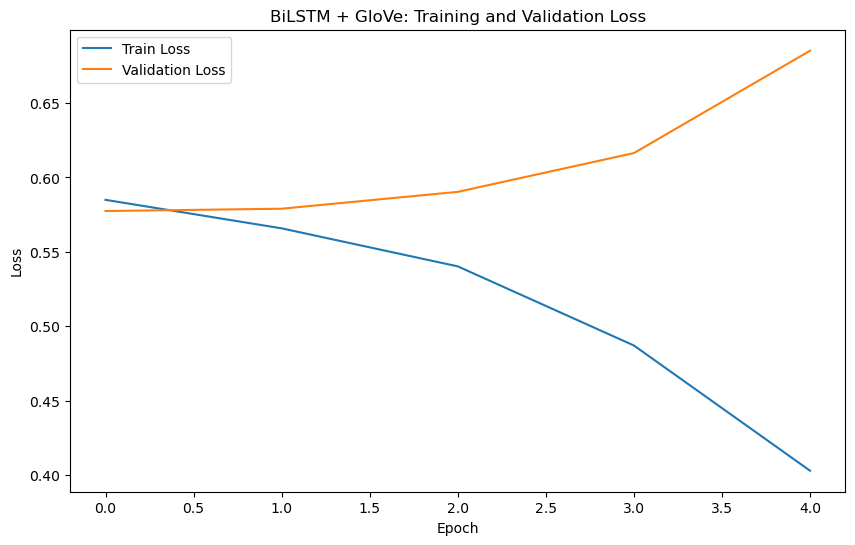

In [1]:
#Bi-LSTM
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# Data preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# Split MBTI type into four binary classification problems
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0
    sn = 1 if mbti_type[1] == 'N' else 0
    tf = 1 if mbti_type[2] == 'T' else 0
    jp = 1 if mbti_type[3] == 'J' else 0
    return [ei, sn, tf, jp]

# Load data
def load_data(file_path):
    # Read data and fix CSV format issues
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    # Check data format, seems like only one column, need to split
    if len(data.columns) == 1:
        # Try to split
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        # Split into two columns (first comma position)
        if "," in column_name:
            # Fix column name
            data.columns = ['combined']
            
            # Try regex to extract MBTI type and posts
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # Create new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                # Try another splitting method
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # Clean quotes
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    # Ensure correct 'type' and 'posts' columns exist
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # Convert string format, clean quotes
    data['posts'] = data['posts'].str.replace("'", "")
    
    # Process text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # Split MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

# Create vocabulary
def build_vocabulary(texts, max_features=10000):
    """Build vocabulary and word-to-index mapping"""
    word_counts = {}
    
    # Count word frequencies
    for text in texts:
        for word in text.split():
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    
    # Select top max_features words by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_words = sorted_words[:max_features]
    
    # Create word-to-index mapping
    word_to_index = {word: idx + 1 for idx, (word, _) in enumerate(sorted_words)}
    
    return word_to_index

# Convert text to index sequences
def texts_to_sequences(texts, word_to_index, max_length=100):
    """Convert texts to index sequences"""
    sequences = []
    
    for text in texts:
        sequence = []
        for word in text.split()[:max_length]:
            if word in word_to_index:
                sequence.append(word_to_index[word])
            else:
                sequence.append(0)  # OOV words
        
        # Pad or truncate to fixed length
        if len(sequence) < max_length:
            sequence += [0] * (max_length - len(sequence))
        else:
            sequence = sequence[:max_length]
        
        sequences.append(sequence)
    
    return np.array(sequences)

# Create mock GloVe embeddings since GloVe file might not be available
def create_mock_glove_embeddings(word_to_index, embedding_dim=100):
    """Create random embedding matrix as substitute for GloVe (when GloVe file is unavailable)"""
    print("Creating mock GloVe embeddings...")
    vocab_size = len(word_to_index) + 1  # +1 for padding/OOV
    embedding_matrix = np.random.randn(vocab_size, embedding_dim).astype('float32')
    # Set padding/OOV vector to zero vector
    embedding_matrix[0] = np.zeros(embedding_dim)
    return embedding_matrix

# Custom dataset
class MBTIGloveDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequences': torch.tensor(self.sequences[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim=128, num_classes=4):
        super(BiLSTMModel, self).__init__()
        
        # Use pretrained GloVe word vectors (or mock embeddings)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True  # Allow fine-tuning
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Word embedding
        embedded = self.embedding(x)
        
        # BiLSTM
        lstm_out, _ = self.lstm(embedded)
        
        # Take output from last time step
        forward_out = lstm_out[:, -1, :self.lstm.hidden_size]
        backward_out = lstm_out[:, 0, self.lstm.hidden_size:]
        lstm_out = torch.cat((forward_out, backward_out), dim=1)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Classification layer
        output = self.fc(lstm_out)
        
        return output

# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")
        
        for batch in train_progress_bar:
            sequences = batch['sequences'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(sequences)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")
            
            for batch in val_progress_bar:
                sequences = batch['sequences'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(sequences)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Convert to binary predictions
                preds = torch.sigmoid(outputs) > 0.5
                
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                
                val_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Calculate evaluation metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_bilstm_model.pth')
            print("Saved best model!")
    
    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_progress_bar = tqdm(test_dataloader, desc="Testing")
        
        for batch in test_progress_bar:
            sequences = batch['sequences'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(sequences)
            
            # Convert to binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Calculate metrics for each dimension
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        dim_prec = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_rec = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    results = {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'dimensions': dim_metrics
    }
    
    return results

# Main function
def main():
    start_time = time.time()
    
    # 1. Data loading and preprocessing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'  # Replace with actual data file path
    data = load_data(file_path)
    
    # 2. Split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. Build vocabulary and convert text to sequences
    print("Building vocabulary...")
    VOCAB_SIZE = 10000
    MAX_LENGTH = 512
    EMBEDDING_DIM = 100
    
    word_to_index = build_vocabulary(X_train, max_features=VOCAB_SIZE)
    print(f"Vocabulary size: {len(word_to_index)}")
    
    print("Converting texts to sequences...")
    X_train_seq = texts_to_sequences(X_train, word_to_index, max_length=MAX_LENGTH)
    X_val_seq = texts_to_sequences(X_val, word_to_index, max_length=MAX_LENGTH)
    X_test_seq = texts_to_sequences(X_test, word_to_index, max_length=MAX_LENGTH)
    
    # 4. Create mock GloVe embedding matrix (since we might not have actual GloVe file)
    embedding_matrix = create_mock_glove_embeddings(word_to_index, embedding_dim=EMBEDDING_DIM)
    
    # 5. Prepare datasets and data loaders
    BATCH_SIZE = 16
    
    train_dataset = MBTIGloveDataset(X_train_seq, y_train)
    val_dataset = MBTIGloveDataset(X_val_seq, y_val)
    test_dataset = MBTIGloveDataset(X_test_seq, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # 6. Initialize model
    print("Initializing BiLSTM model...")
    model = BiLSTMModel(
        vocab_size=len(word_to_index) + 1,  # +1 for padding/OOV
        embedding_dim=EMBEDDING_DIM,
        embedding_matrix=embedding_matrix,
        hidden_dim=128,
        num_classes=4
    )
    model.to(device)
    
    # 7. Training setup
    EPOCHS = 5
    LEARNING_RATE = 1e-3
    
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    
    # 8. Train model
    print("Training model...")
    train_losses, val_losses = train_model(
        model, 
        train_dataloader, 
        val_dataloader, 
        optimizer, 
        criterion, 
        EPOCHS
    )
    
    # 9. Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('BiLSTM + GloVe: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('bilstm_training_loss.png')
    
    # 10. Load best model and evaluate
    print("Evaluating best model...")
    model.load_state_dict(torch.load('best_bilstm_model.pth'))
    results = evaluate_model(model, test_dataloader)
    
    # 11. Output results
    print("\nModel: BiLSTM + GloVe")
    print(f"Training time: {(time.time() - start_time):.2f} seconds")
    
    print("\nOverall Results:")
    print(f"Accuracy: {results['overall']['accuracy']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1 Score: {results['overall']['f1']:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in results['dimensions']:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")

if __name__ == "__main__":
    main()

start
Using cuda
Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Initializing pure RoBERTa model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model...
Epoch 1/5


Validation: 100%|██████████| 82/82 [00:46<00:00,  1.78it/s, loss=0.699]


Train Loss: 0.5674
Val Loss: 0.5053
Accuracy: 0.3436
Precision: 0.7337
Recall: 0.5416
F1 Score: 0.5871
Saved best model!
Epoch 2/5


Validation: 100%|██████████| 82/82 [00:48<00:00,  1.68it/s, loss=0.901]


Train Loss: 0.4208
Val Loss: 0.3896
Accuracy: 0.5865
Precision: 0.8244
Recall: 0.7397
F1 Score: 0.7764
Saved best model!
Epoch 3/5


Validation: 100%|██████████| 82/82 [00:48<00:00,  1.69it/s, loss=0.967]


Train Loss: 0.3476
Val Loss: 0.3837
Accuracy: 0.5880
Precision: 0.7961
Recall: 0.8046
F1 Score: 0.7947
Saved best model!
Epoch 4/5


Validation: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s, loss=1.02] 


Train Loss: 0.3066
Val Loss: 0.3813
Accuracy: 0.6188
Precision: 0.8400
Recall: 0.7599
F1 Score: 0.7944
Saved best model!
Epoch 5/5


Validation: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s, loss=1.08] 


Train Loss: 0.2758
Val Loss: 0.3910
Accuracy: 0.6149
Precision: 0.8253
Recall: 0.7705
F1 Score: 0.7952
Evaluating best model...


Testing: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]



Model: Pure RoBERTa
Training time: 3792.05 seconds

Overall Results:
Accuracy: 0.5837
Precision: 0.8249
Recall: 0.7223
F1 Score: 0.7649

Results by MBTI Dimension:

E/I:
  Accuracy: 0.8533
  Precision: 0.7755
  Recall: 0.5084
  F1 Score: 0.6141

S/N:
  Accuracy: 0.8963
  Precision: 0.9191
  Recall: 0.9643
  F1 Score: 0.9411

T/F:
  Accuracy: 0.8180
  Precision: 0.8309
  Recall: 0.7604
  F1 Score: 0.7941

J/P:
  Accuracy: 0.7896
  Precision: 0.7742
  Recall: 0.6562
  F1 Score: 0.7104


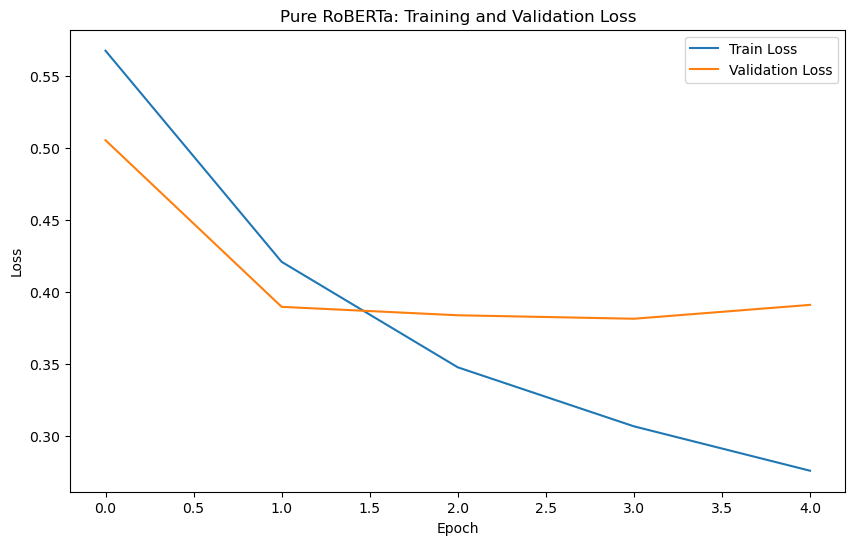

In [2]:
#bert
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')
print("start")

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# Data preprocessing
def preprocess_text(text):
    # Same preprocessing steps as RCNN-RoBERTa model
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# Split MBTI type into four binary classification problems
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0  # Extraversion vs Introversion
    sn = 1 if mbti_type[1] == 'N' else 0  # Intuition vs Sensing
    tf = 1 if mbti_type[2] == 'T' else 0  # Thinking vs Feeling
    jp = 1 if mbti_type[3] == 'J' else 0  # Judging vs Perceiving
    return [ei, sn, tf, jp]

# Load data
def load_data(file_path):
    # Read data and fix CSV format issues
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    # Check data format, seems like only one column, need to split
    if len(data.columns) == 1:
        # Try to split
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        # Split into two columns (first comma position)
        if "," in column_name:
            # Fix column name
            data.columns = ['combined']
            
            # Try regex to extract MBTI type and posts
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # Create new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                # Try another splitting method
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # Clean quotes
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    # Ensure correct 'type' and 'posts' columns exist
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # Convert string format, clean quotes
    data['posts'] = data['posts'].str.replace("'", "")
    
    # Process text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # Split MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

# Custom dataset
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        
        # Truncate overly long text, keep last max_length tokens
        if len(text) > self.max_length * 4:  # Rough estimate, one token ≈ 4 characters
            text = text[-self.max_length * 4:]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Pure RoBERTa model - without RCNN components
class PureRoBERTaModel(nn.Module):
    def __init__(self, num_classes=4):
        super(PureRoBERTaModel, self).__init__()
        
        # Load pretrained RoBERTa model
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        
        # Classifier directly connected to RoBERTa output
        self.classifier = nn.Linear(768, num_classes)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_ids, attention_mask):
        # RoBERTa encoding
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use final hidden state of [CLS] token as sentence representation
        pooled_output = roberta_output.last_hidden_state[:, 0, :]
        
        # Apply dropout and classifier
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

# Get linear learning rate scheduler
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """Create linear learning rate scheduler with warmup"""
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))
    
    return get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")
        
        for batch in train_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            train_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")
            
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Convert to binary predictions
                preds = torch.sigmoid(outputs) > 0.5
                
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                
                val_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Calculate evaluation metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_pure_roberta_model.pth')
            print("Saved best model!")
    
    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_progress_bar = tqdm(test_dataloader, desc="Testing")
        
        for batch in test_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            
            # Convert to binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Calculate metrics for each dimension
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        dim_prec = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_rec = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    results = {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'dimensions': dim_metrics
    }
    
    return results

# Main function
def main():
    start_time = time.time()
    
    # 1. Data loading and preprocessing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'  # Replace with actual data file path
    data = load_data(file_path)
    
    # 2. Split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. Data preparation
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Use same batch size and max length as RCNN-RoBERTa
    BATCH_SIZE = 16
    MAX_LENGTH = 512
    
    train_dataset = MBTIDataset(X_train, y_train, tokenizer, max_length=MAX_LENGTH)
    val_dataset = MBTIDataset(X_val, y_val, tokenizer, max_length=MAX_LENGTH)
    test_dataset = MBTIDataset(X_test, y_test, tokenizer, max_length=MAX_LENGTH)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # 4. Model initialization
    print("Initializing pure RoBERTa model...")
    model = PureRoBERTaModel(num_classes=4)
    model.to(device)
    
    # 5. Training setup - use same hyperparameters as RCNN-RoBERTa
    EPOCHS = 5
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 1e-5
    ADAM_EPSILON = 1e-6
    
    # Total training steps
    total_steps = len(train_dataloader) * EPOCHS
    
    # Optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        eps=ADAM_EPSILON,
        weight_decay=WEIGHT_DECAY
    )
    
    # Learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # 6. Train model
    print("Training model...")
    train_losses, val_losses = train_model(
        model, 
        train_dataloader, 
        val_dataloader, 
        optimizer, 
        scheduler, 
        criterion, 
        EPOCHS
    )
    
    # 7. Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Pure RoBERTa: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('pure_roberta_training_loss.png')
    
    # 8. Load best model and evaluate
    print("Evaluating best model...")
    model.load_state_dict(torch.load('best_pure_roberta_model.pth'))
    results = evaluate_model(model, test_dataloader)
    
    # 9. Output results
    print("\nModel: Pure RoBERTa")
    print(f"Training time: {(time.time() - start_time):.2f} seconds")
    
    print("\nOverall Results:")
    print(f"Accuracy: {results['overall']['accuracy']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1 Score: {results['overall']['f1']:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in results['dimensions']:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")

if __name__ == "__main__":
    main()

Using cuda
Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Building vocabulary...
Vocabulary size: 10000
Initializing CNN model...
Training model...
Epoch 1/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 328.19it/s, loss=0.814]


Train Loss: 0.6370
Val Loss: 0.5814
Accuracy: 0.2975
Precision: 0.6737
Recall: 0.5616
F1 Score: 0.5462
Saved best model!
Epoch 2/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 362.12it/s, loss=0.754]


Train Loss: 0.5569
Val Loss: 0.5047
Accuracy: 0.3966
Precision: 0.7891
Recall: 0.4860
F1 Score: 0.5337
Saved best model!
Epoch 3/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 313.47it/s, loss=0.785]


Train Loss: 0.5255
Val Loss: 0.4778
Accuracy: 0.4420
Precision: 0.7554
Recall: 0.5976
F1 Score: 0.6467
Saved best model!
Epoch 4/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 363.30it/s, loss=0.816]


Train Loss: 0.5011
Val Loss: 0.4706
Accuracy: 0.4712
Precision: 0.7404
Recall: 0.6752
F1 Score: 0.6949
Saved best model!
Epoch 5/5


Validation: 100%|██████████| 82/82 [00:00<00:00, 367.78it/s, loss=0.855]


Train Loss: 0.4805
Val Loss: 0.4595
Accuracy: 0.4643
Precision: 0.7797
Recall: 0.6012
F1 Score: 0.6515
Saved best model!
Evaluating best model...


Testing: 100%|██████████| 82/82 [00:00<00:00, 580.40it/s]



Model: CNN with Embeddings
Training time: 20.55 seconds

Overall Results:
Accuracy: 0.4416
Precision: 0.7557
Recall: 0.5986
F1 Score: 0.6425

Results by MBTI Dimension:

E/I:
  Accuracy: 0.8026
  Precision: 0.6909
  Recall: 0.2542
  F1 Score: 0.3716

S/N:
  Accuracy: 0.8671
  Precision: 0.8736
  Recall: 0.9884
  F1 Score: 0.9275

T/F:
  Accuracy: 0.7488
  Precision: 0.7362
  Recall: 0.7105
  F1 Score: 0.7231

J/P:
  Accuracy: 0.7135
  Precision: 0.7220
  Recall: 0.4414
  F1 Score: 0.5479


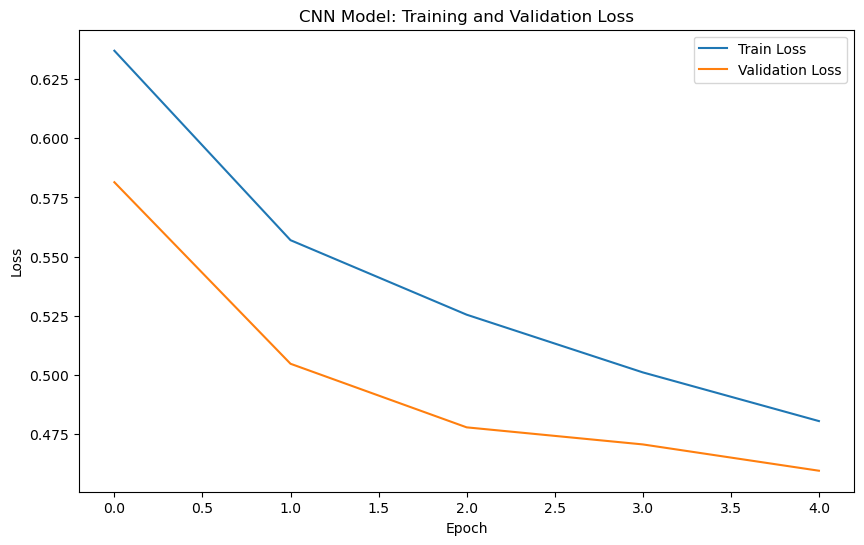

In [4]:
#CNN
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# Data preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# Split MBTI type into four binary classification problems
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0  # Extraversion vs Introversion
    sn = 1 if mbti_type[1] == 'N' else 0  # Intuition vs Sensing
    tf = 1 if mbti_type[2] == 'T' else 0  # Thinking vs Feeling
    jp = 1 if mbti_type[3] == 'J' else 0  # Judging vs Perceiving
    return [ei, sn, tf, jp]

# Load data
def load_data(file_path):
    # Read data and fix CSV format issues
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    # Check data format, seems like only one column, need to split
    if len(data.columns) == 1:
        # Try to split
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        # Split into two columns (first comma position)
        if "," in column_name:
            # Fix column name
            data.columns = ['combined']
            
            # Try regex to extract MBTI type and posts
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # Create new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                # Try another splitting method
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # Clean quotes
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    # Ensure correct 'type' and 'posts' columns exist
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # Convert string format, clean quotes
    data['posts'] = data['posts'].str.replace("'", "")
    
    # Process text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # Split MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

# Create vocabulary
def build_vocabulary(texts, max_features=10000):
    """Build vocabulary and word-to-index mapping"""
    print("Building vocabulary...")
    word_counts = {}
    
    for text in texts:
        for word in text.split():
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    
    # Select top max_features words by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    if max_features < len(sorted_words):
        sorted_words = sorted_words[:max_features]
    
    # Create word-to-index mapping
    word_to_index = {word: idx + 1 for idx, (word, _) in enumerate(sorted_words)}
    
    print(f"Vocabulary size: {len(word_to_index)}")
    return word_to_index

# Convert text to index sequences
def texts_to_sequences(texts, word_to_index, max_length=200):
    """Convert texts to index sequences"""
    sequences = []
    
    for text in texts:
        sequence = []
        for word in text.split()[:max_length]:
            if word in word_to_index:
                sequence.append(word_to_index[word])
            else:
                sequence.append(0)  # OOV words
        
        # Pad or truncate to fixed length
        if len(sequence) < max_length:
            sequence += [0] * (max_length - len(sequence))
        else:
            sequence = sequence[:max_length]
        
        sequences.append(sequence)
    
    return np.array(sequences)

# Custom dataset
class MBTITextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequences': torch.tensor(self.sequences[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# CNN model
class CNNTextModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, filter_sizes=[3, 4, 5], num_filters=100, num_classes=4, dropout=0.5):
        super(CNNTextModel, self).__init__()
        
        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=size)
            for size in filter_sizes
        ])
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        
    def forward(self, x):
        # Word embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # Transpose for convolution operation
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        
        # Apply convolution for each filter size
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        
        # Apply max pooling to each convolution result
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Concatenate all pooled results
        cat = torch.cat(pooled, dim=1)
        
        # Apply dropout and connect to fully connected layer
        out = self.dropout(cat)
        out = self.fc(out)
        
        return out

# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")
        
        for batch in train_progress_bar:
            sequences = batch['sequences'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(sequences)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")
            
            for batch in val_progress_bar:
                sequences = batch['sequences'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(sequences)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Convert to binary predictions
                preds = torch.sigmoid(outputs) > 0.5
                
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                
                val_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Calculate evaluation metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            print("Saved best model!")
    
    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_progress_bar = tqdm(test_dataloader, desc="Testing")
        
        for batch in test_progress_bar:
            sequences = batch['sequences'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(sequences)
            
            # Convert to binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Calculate metrics for each dimension
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        dim_prec = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_rec = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    results = {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'dimensions': dim_metrics
    }
    
    return results

# Main function
def main():
    start_time = time.time()
    
    # 1. Data loading and preprocessing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'  # Replace with actual data file path
    data = load_data(file_path)
    
    # 2. Split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. Build vocabulary
    VOCAB_SIZE = 10000
    word_to_index = build_vocabulary(X_train, max_features=VOCAB_SIZE)
    
    # 4. Convert text to sequences
    MAX_LENGTH = 512
    X_train_seq = texts_to_sequences(X_train, word_to_index, max_length=MAX_LENGTH)
    X_val_seq = texts_to_sequences(X_val, word_to_index, max_length=MAX_LENGTH)
    X_test_seq = texts_to_sequences(X_test, word_to_index, max_length=MAX_LENGTH)
    
    # 5. Prepare datasets and data loaders
    BATCH_SIZE = 16
    
    train_dataset = MBTITextDataset(X_train_seq, y_train)
    val_dataset = MBTITextDataset(X_val_seq, y_val)
    test_dataset = MBTITextDataset(X_test_seq, y_test)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # 6. Initialize model
    print("Initializing CNN model...")
    EMBEDDING_DIM = 100
    model = CNNTextModel(
        vocab_size=len(word_to_index) + 1,  # +1 for padding/OOV
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=[3, 4, 5],
        num_filters=100,
        num_classes=4,
        dropout=0.5
    )
    model.to(device)
    
    # 7. Training setup
    EPOCHS = 5
    LEARNING_RATE = 1e-3
    
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    
    # 8. Train model
    print("Training model...")
    train_losses, val_losses = train_model(
        model, 
        train_dataloader, 
        val_dataloader, 
        optimizer, 
        criterion, 
        EPOCHS
    )
    
    # 9. Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('CNN Model: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('cnn_training_loss.png')
    
    # 10. Load best model and evaluate
    print("Evaluating best model...")
    model.load_state_dict(torch.load('best_cnn_model.pth'))
    results = evaluate_model(model, test_dataloader)
    
    # 11. Output results
    print("\nModel: CNN with Embeddings")
    print(f"Training time: {(time.time() - start_time):.2f} seconds")
    
    print("\nOverall Results:")
    print(f"Accuracy: {results['overall']['accuracy']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1 Score: {results['overall']['f1']:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in results['dimensions']:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")

if __name__ == "__main__":
    main()

Using cuda
Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Initializing BERT-base model...
Training model...
Epoch 1/5


Validation: 100%|██████████| 82/82 [00:53<00:00,  1.54it/s, loss=0.734]


Train Loss: 0.5279
Val Loss: 0.4601
Accuracy: 0.4650
Precision: 0.7640
Recall: 0.6603
F1 Score: 0.6968
Saved best model!
Epoch 2/5


Validation: 100%|██████████| 82/82 [01:03<00:00,  1.30it/s, loss=0.721]


Train Loss: 0.4122
Val Loss: 0.4026
Accuracy: 0.5749
Precision: 0.7882
Recall: 0.7721
F1 Score: 0.7751
Saved best model!
Epoch 3/5


Validation: 100%|██████████| 82/82 [01:13<00:00,  1.12it/s, loss=0.672]


Train Loss: 0.3369
Val Loss: 0.3825
Accuracy: 0.5957
Precision: 0.8208
Recall: 0.7615
F1 Score: 0.7829
Saved best model!
Epoch 4/5


Validation: 100%|██████████| 82/82 [00:37<00:00,  2.19it/s, loss=0.722]


Train Loss: 0.2808
Val Loss: 0.3892
Accuracy: 0.6003
Precision: 0.8204
Recall: 0.7652
F1 Score: 0.7893
Epoch 5/5


Validation: 100%|██████████| 82/82 [01:14<00:00,  1.10it/s, loss=0.749]


Train Loss: 0.2448
Val Loss: 0.3930
Accuracy: 0.6103
Precision: 0.8128
Recall: 0.7810
F1 Score: 0.7947
Evaluating best model...


Testing: 100%|██████████| 82/82 [01:06<00:00,  1.22it/s]



Model: BERT-base
Training time: 3611.20 seconds

Overall Results:
Accuracy: 0.5730
Precision: 0.8038
Recall: 0.7226
F1 Score: 0.7508

Results by MBTI Dimension:

E/I:
  Accuracy: 0.8372
  Precision: 0.7636
  Recall: 0.4214
  F1 Score: 0.5431

S/N:
  Accuracy: 0.8925
  Precision: 0.9320
  Recall: 0.9437
  F1 Score: 0.9378

T/F:
  Accuracy: 0.8264
  Precision: 0.8130
  Recall: 0.8103
  F1 Score: 0.8117

J/P:
  Accuracy: 0.7711
  Precision: 0.7066
  Recall: 0.7148
  F1 Score: 0.7107


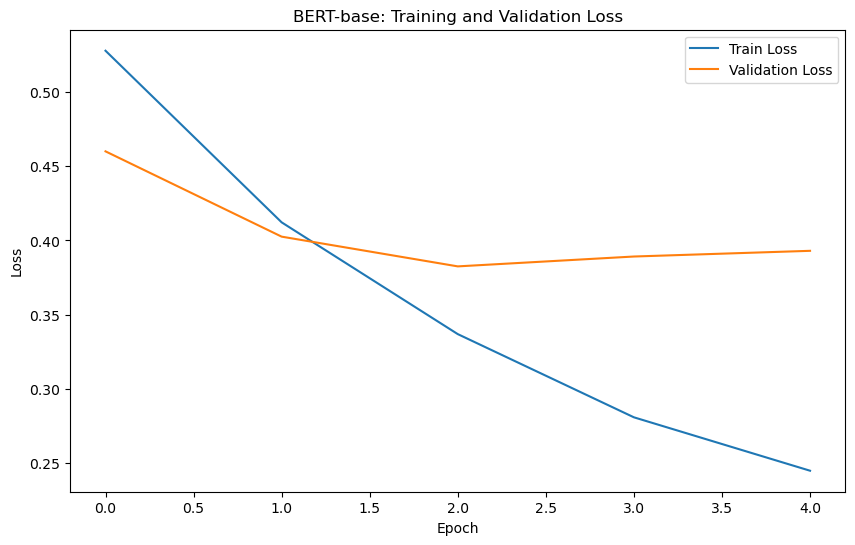

In [5]:
#bert-base
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

# Data preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# Split MBTI type into four binary classification problems
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0  # Extraversion vs Introversion
    sn = 1 if mbti_type[1] == 'N' else 0  # Intuition vs Sensing
    tf = 1 if mbti_type[2] == 'T' else 0  # Thinking vs Feeling
    jp = 1 if mbti_type[3] == 'J' else 0  # Judging vs Perceiving
    return [ei, sn, tf, jp]

# Load data
def load_data(file_path):
    # Read data and fix CSV format issues
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    # Check data format, seems like only one column, need to split
    if len(data.columns) == 1:
        # Try to split
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        # Split into two columns (first comma position)
        if "," in column_name:
            # Fix column name
            data.columns = ['combined']
            
            # Try regex to extract MBTI type and posts
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # Create new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                # Try another splitting method
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # Clean quotes
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    # Ensure correct 'type' and 'posts' columns exist
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # Convert string format, clean quotes
    data['posts'] = data['posts'].str.replace("'", "")
    
    # Process text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # Split MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

# Custom dataset
class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        
        # Truncate overly long text, keep last max_length tokens
        if len(text) > self.max_length * 4:  # Rough estimate, one token ≈ 4 characters
            text = text[-self.max_length * 4:]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# BERT-base model
class BERTBaseModel(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTBaseModel, self).__init__()
        
        # Load pretrained BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        
        # Classifier directly connected to BERT output
        self.classifier = nn.Linear(768, num_classes)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, input_ids, attention_mask):
        # BERT encoding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use final hidden state of [CLS] token as sentence representation
        pooled_output = outputs.pooler_output
        
        # Apply dropout and classifier
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

# Get linear learning rate scheduler
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """Create linear learning rate scheduler with warmup"""
    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))
    
    return get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

# Training function
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_progress_bar = tqdm(train_dataloader, desc="Training")
        
        for batch in train_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            train_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc="Validation")
            
            for batch in val_progress_bar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Convert to binary predictions
                preds = torch.sigmoid(outputs) > 0.5
                
                all_preds.extend(preds.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
                
                val_progress_bar.set_postfix({'loss': loss.item()})
        
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        # Calculate evaluation metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_bert_base_model.pth')
            print("Saved best model!")
    
    return train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_progress_bar = tqdm(test_dataloader, desc="Testing")
        
        for batch in test_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            
            # Convert to binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Calculate metrics for each dimension
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        dim_prec = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_rec = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        dim_f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    results = {
        'overall': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        },
        'dimensions': dim_metrics
    }
    
    return results

# Main function
def main():
    start_time = time.time()
    
    # 1. Data loading and preprocessing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'  # Replace with actual data file path
    data = load_data(file_path)
    
    # 2. Split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. Data preparation
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Set batch size and max length
    BATCH_SIZE = 16
    MAX_LENGTH = 512
    
    train_dataset = MBTIDataset(X_train, y_train, tokenizer, max_length=MAX_LENGTH)
    val_dataset = MBTIDataset(X_val, y_val, tokenizer, max_length=MAX_LENGTH)
    test_dataset = MBTIDataset(X_test, y_test, tokenizer, max_length=MAX_LENGTH)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    # 4. Model initialization
    print("Initializing BERT-base model...")
    model = BERTBaseModel(num_classes=4)
    model.to(device)
    
    # 5. Training setup
    EPOCHS = 5
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 1e-5
    ADAM_EPSILON = 1e-6
    
    # Total training steps
    total_steps = len(train_dataloader) * EPOCHS
    
    # Optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        eps=ADAM_EPSILON,
        weight_decay=WEIGHT_DECAY
    )
    
    # Learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Loss function
    criterion = nn.BCEWithLogitsLoss()
    
    # 6. Train model
    print("Training model...")
    train_losses, val_losses = train_model(
        model, 
        train_dataloader, 
        val_dataloader, 
        optimizer, 
        scheduler, 
        criterion, 
        EPOCHS
    )
    
    # 7. Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('BERT-base: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('bert_base_training_loss.png')
    
    # 8. Load best model and evaluate
    print("Evaluating best model...")
    model.load_state_dict(torch.load('best_bert_base_model.pth'))
    results = evaluate_model(model, test_dataloader)
    
    # 9. Output results
    print("\nModel: BERT-base")
    print(f"Training time: {(time.time() - start_time):.2f} seconds")
    
    print("\nOverall Results:")
    print(f"Accuracy: {results['overall']['accuracy']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1 Score: {results['overall']['f1']:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in results['dimensions']:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")

if __name__ == "__main__":
    main()

In [3]:
# KNN + XGBoost Ensemble
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\|\|\|', ' ', text)
    return text.strip()

# spit mbti classification to 4 bi-classify task
def split_mbti_type(mbti_type):
    ei = 1 if mbti_type[0] == 'E' else 0
    sn = 1 if mbti_type[1] == 'N' else 0
    tf = 1 if mbti_type[2] == 'T' else 0
    jp = 1 if mbti_type[3] == 'J' else 0
    return [ei, sn, tf, jp]

def load_data(file_path):
    # load data
    data = pd.read_csv(file_path)
    print(f"Original columns: {data.columns}")
    
    if len(data.columns) == 1:
        column_name = data.columns[0]
        print(f"Splitting column: {column_name}")
        
        if "," in column_name:
            data.columns = ['combined']
            
            # extract important text
            data_list = []
            for row in data['combined']:
                match = re.match(r'(\w+),"(.*)"', row)
                if match:
                    mbti_type = match.group(1)
                    posts = match.group(2)
                    data_list.append({
                        'type': mbti_type,
                        'posts': posts
                    })
            
            # buit new DataFrame
            if data_list:
                data = pd.DataFrame(data_list)
                print(f"Successfully extracted data, new columns: {data.columns}")
                print(f"Data shape: {data.shape}")
            else:
                #try another spit
                print("Trying another splitting method...")
                parts = data['combined'].str.split(',', n=1)
                data['type'] = parts.str[0]
                data['posts'] = parts.str[1:].str.join(',')
                # clean
                data['type'] = data['type'].str.strip('"')
                data['posts'] = data['posts'].str.strip().str.strip('"')
    
    if 'type' not in data.columns or 'posts' not in data.columns:
        raise ValueError("Couldn't properly extract 'type' and 'posts' from the data file!")
    
    print(f"Final data columns: {data.columns}")
    
    # remove signify
    data['posts'] = data['posts'].str.replace("'", "")
    
    # deal with the text
    data['processed_posts'] = data['posts'].apply(preprocess_text)
    
    # split the MBTI type
    mbti_binary = data['type'].apply(split_mbti_type)
    data['EI'] = [x[0] for x in mbti_binary]
    data['SN'] = [x[1] for x in mbti_binary]
    data['TF'] = [x[2] for x in mbti_binary]
    data['JP'] = [x[3] for x in mbti_binary]
    
    return data

class KNNXGBoostEnsemble:
    def __init__(self, n_neighbors=5, xgb_params=None):
        self.n_neighbors = n_neighbors
        self.xgb_params = xgb_params or {
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.1,
            'random_state': 42,
            'eval_metric': 'logloss'
        }
        
        # built classifier for every dimention
        self.models = []
        
    def _create_single_ensemble(self):
        # KNN
        knn = KNeighborsClassifier(
            n_neighbors=self.n_neighbors,
            metric='cosine',
            weights='distance'
        )
        
        # XGBoost
        xgb = XGBClassifier(**self.xgb_params)
        
        # built poll
        ensemble = VotingClassifier(
            estimators=[
                ('knn', knn),
                ('xgb', xgb)
            ],
            voting='soft'  # soft vote
        )
        
        return ensemble
    
    def fit(self, X, y):
        """train esemble model"""
        self.models = []
        
        print("Training KNN+XGBoost ensemble...")
        for i in range(4):  # 4 d
            print(f"Training dimension {i+1}/4...")
            
            # built single dimentional model
            ensemble = self._create_single_ensemble()
            
            # train
            ensemble.fit(X, y[:, i])
            
            self.models.append(ensemble)
    
    def predict(self, X):
        """forecast"""
        predictions = []
        
        for i, model in enumerate(self.models):
            pred = model.predict(X)
            predictions.append(pred)
        
        return np.column_stack(predictions)
    
    def predict_proba(self, X):
        """prediction"""
        probabilities = []
        
        for i, model in enumerate(self.models):
            # positive sample possibility
            proba = model.predict_proba(X)[:, 1]
            probabilities.append(proba)
        
        return np.column_stack(probabilities)


def main():
    start_time = time.time()
    
    # 1. dataload and preprocesing
    print("Loading and preprocessing data...")
    file_path = 'C:\\Users\\Ada39\\Desktop\\ENEG8535\\group_project\\MBTI\\mbti_1.csv'  # 替换为实际数据文件路径
    data = load_data(file_path)
    
    # 2. split dataset
    X = data['processed_posts'].values
    y = np.array(list(zip(data['EI'], data['SN'], data['TF'], data['JP'])))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['type'])
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    
    # 3. feature extract
    print("Extracting TF-IDF features...")
    vectorizer = TfidfVectorizer(
        max_features=5000, 
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95 #ignore some words high frequency or low frequency
    )
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # convert to dense dataset
    print("Converting to dense arrays...")
    X_train_dense = X_train_tfidf.toarray()
    X_val_dense = X_val_tfidf.toarray()
    X_test_dense = X_test_tfidf.toarray()
    
    # 4. train the esemble model
    print("Training KNN+XGBoost ensemble model...")
    
    # XGBoost configuration
    xgb_params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'eval_metric': 'logloss',
        'verbosity': 0 
    }
    
    # esnemble model
    ensemble_model = KNNXGBoostEnsemble(
        n_neighbors=5,
        xgb_params=xgb_params
    )
    
    # train
    ensemble_model.fit(X_train_dense, y_train)
    
    # 5. evaluate
    print("Validating model...")
    train_preds = ensemble_model.predict(X_train_dense)
    val_preds = ensemble_model.predict(X_val_dense)
    
    train_acc = accuracy_score(y_train, train_preds)
    val_acc = accuracy_score(y_val, val_preds)
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # 6. test 
    print("Evaluating model...")
    test_preds = ensemble_model.predict(X_test_dense)
    
    # overall metric
    accuracy = accuracy_score(y_test, test_preds)
    precision = precision_score(y_test, test_preds, average='macro', zero_division=0)
    recall = recall_score(y_test, test_preds, average='macro', zero_division=0)
    f1 = f1_score(y_test, test_preds, average='macro', zero_division=0)
    
    # calculate the dimentional metric
    dim_names = ['E/I', 'S/N', 'T/F', 'J/P']
    dim_metrics = []
    
    for i in range(4):
        dim_acc = accuracy_score(y_test[:, i], test_preds[:, i])
        dim_prec = precision_score(y_test[:, i], test_preds[:, i], zero_division=0)
        dim_rec = recall_score(y_test[:, i], test_preds[:, i], zero_division=0)
        dim_f1 = f1_score(y_test[:, i], test_preds[:, i], zero_division=0)
        
        dim_metrics.append({
            'dimension': dim_names[i],
            'accuracy': dim_acc,
            'precision': dim_prec,
            'recall': dim_rec,
            'f1': dim_f1
        })
    
    # 7. result
    print("\nModel: KNN + XGBoost Ensemble")
    print(f"Training time: {(time.time() - start_time):.2f} seconds")
    
    print("\nOverall Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nResults by MBTI Dimension:")
    for dim in dim_metrics:
        print(f"\n{dim['dimension']}:")
        print(f"  Accuracy: {dim['accuracy']:.4f}")
        print(f"  Precision: {dim['precision']:.4f}")
        print(f"  Recall: {dim['recall']:.4f}")
        print(f"  F1 Score: {dim['f1']:.4f}")
    

if __name__ == "__main__":
    main()

Loading and preprocessing data...
Original columns: Index(['type', 'posts'], dtype='object')
Final data columns: Index(['type', 'posts'], dtype='object')
Train size: 6072, Validation size: 1301, Test size: 1302
Extracting TF-IDF features...
Converting to dense arrays...
Training KNN+XGBoost ensemble model...
Training KNN+XGBoost ensemble...
Training dimension 1/4...
Training dimension 2/4...
Training dimension 3/4...
Training dimension 4/4...
Validating model...
Train Accuracy: 1.0000
Validation Accuracy: 0.5611
Evaluating model...

Model: KNN + XGBoost Ensemble
Training time: 146.09 seconds

Overall Results:
Accuracy: 0.5661
Precision: 0.8399
Recall: 0.7002
F1 Score: 0.7511

Results by MBTI Dimension:

E/I:
  Accuracy: 0.8402
  Precision: 0.7935
  Recall: 0.4114
  F1 Score: 0.5419

S/N:
  Accuracy: 0.8932
  Precision: 0.8945
  Recall: 0.9929
  F1 Score: 0.9411

T/F:
  Accuracy: 0.8134
  Precision: 0.8638
  Recall: 0.7072
  F1 Score: 0.7777

J/P:
  Accuracy: 0.8134
  Precision: 0.8078
